In [1]:
import warnings
import pandas as pd
from matplotlib import pyplot as plt
from aeon.visualisation import plot_series
from sklearn.metrics import mean_absolute_percentage_error as mape
from all_functions import *
import os
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
def get_each_point_error(path, val_date):
    df = pd.read_csv(path, sep=";")
    
    df_filtered = df[df['test_range'] <= val_date].copy()

    df_filtered = df_filtered.iloc[::-1]
    
    error_series_concatenated = []
    for _, row in df_filtered.iterrows():
        error_series_str = row['error_series']
        error_list = ast.literal_eval(error_series_str)
        error_series_concatenated.append(error_list)
    return error_series_concatenated


def get_error_series(path, test_date):
    df = pd.read_csv(path, sep=";")
    error_series_str = df.loc[df['test_range'] == test_date, 'error_series'].values[0]
    error_list_rf = ast.literal_eval(error_series_str)
    return error_list_rf

def get_all_error_series(path, val_date):
    df = pd.read_csv(path, sep=";")
    
    df_filtered = df[df['test_range'] <= val_date].copy()

    df_filtered = df_filtered.iloc[::-1]
    
    error_series_concatenated = []
    for _, row in df_filtered.iterrows():
        error_series_str = row['error_series']
        error_list = ast.literal_eval(error_series_str)
        error_series_concatenated.extend(error_list)
    
    return error_series_concatenated

def generate_index(start_date, end_date):
    end_date_dt = pd.to_datetime(end_date)
    
    start_date_dt = pd.to_datetime(start_date)
    
    index = pd.period_range(start=start_date_dt, end=end_date_dt, freq='M')

    return index

def get_test_real(series, start_date, end_date):
    start_period = pd.to_datetime(start_date).to_period('M')
    end_period = (pd.to_datetime(end_date))
    
    filtered_series = series.loc[start_period:end_period]

    return filtered_series

def get_train_real(series, start_date):
    start_period = pd.to_datetime(start_date).to_period('M')
    
    filtered_series = series[series.index < start_period]

    return filtered_series

def preds_recursive_meta(example, model, horizon):
  preds = []
  for i in range(horizon):
    pred = model.predict(example)[0]
    preds.append(pred)

    example = example[:,1:]

    example = np.append(example, pred)
    example = example.reshape(1,-1)
  return preds

def get_preds_hybrid(path, test_date, start_index):
    df = pd.read_csv(path, sep=";")
    results = {}
    filtered_df = df[df['test_range'] == test_date]
    columns_p1_to_p12 = filtered_df.loc[:, 'P1':'P12']
    values_list = columns_p1_to_p12.values.flatten().tolist()     
    results = pd.Series(values_list, index=start_index)
    return results


def save_csv(nome, csv_file, uf, derivado, models, series, test, preds, horizon=12, window=12):
    y_baseline = series[-horizon*2:-horizon].values
    rmse_result = rmse(test, preds)
    mape_result = mape(test, preds)
    pocid_result = pocid(test, preds)
    pbe_result = pbe(test, preds)
    mcpm_result = mcpm(rmse_result, mape_result, pocid_result)
    mase_result = mase(test, preds, y_baseline)

    df_result = pd.DataFrame({'DATA': nome, 'UF': uf, 'PRODUCT': derivado, 'MODEL':  f"{'_'.join(models)}", 'PARAMS': str({}), 'WINDOW': window, 'HORIZON': horizon,  
                                            'RMSE': rmse_result, 'MAPE': mape_result, 'POCID': pocid_result, 'PBE': pbe_result, 'MASE': mase_result,
                                            'P1': preds[0], 'P2': preds[1], 'P3': preds[2], 'P4': preds[3], 'P5': preds[4],
                                            'P6': preds[5], 'P7': preds[6], 'P8': preds[7], 'P9': preds[8], 'P10': preds[9],
                                            'P11': preds[10], 'P12': preds[11]
                                            }, index=[0])
    df_result.to_csv(csv_file, sep=';', mode='a', header=False, index=False)

In [5]:
def meta_learner_erro(model_target, transform_target, test_date, val_date):
    transformations = ['normal', 'deseasonal', 'log']
    models = ["knn", "rf", "deepar", "svr", "catboost", "arima"]
    noResid = True

    horizon = 12
    window = 12
    dirs = [
        '../datasets/venda/mensal/uf/gasolinac/',
        '../datasets/venda/mensal/uf/etanolhidratado/',
        '../datasets/venda/mensal/uf/glp/',
        '../datasets/venda/mensal/uf/oleodiesel/',
    ]
    colunas = ['DATA', 'UF', 'PRODUCT', 'MODEL', 'PARAMS', 'WINDOW', 'HORIZON', 'RMSE', 'MAPE', 'POCID', 'PBE', 'MASE',
           'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12',
           ]
    start_date, end_date = test_date.split('_')
    test_index = generate_index(start_date, end_date)

    results_file = f'./combination_error/untagged/{test_date}'
  
    for directory in dirs:
        for file in os.listdir(directory):
            if file.endswith('.csv'):
                uf = file.split("_")[1].upper()
                derivado = file.split("_")[2].split(".")[0]
                full_path = os.path.join(directory, file)
                series = read_series(full_path)
                test_real = get_test_real(series, start_date, end_date)
                erros = pd.DataFrame()
                preds_start = []
                for model in models:
                    for transform in transformations:
                        error_serie = get_all_error_series(
                            f'./results/{model}/{derivado}/{transform}/transform_{uf}.csv', 
                            val_date
                        )

                        #condicao para retirar o ponto de partida (X_test) do train
                        if model == model_target and transform == transform_target:
                            preds_start = error_serie[-12:]
                            error_serie = error_serie[:-12]
                        
                        data = rolling_window(error_serie, 12)
                        erros = pd.concat([data, erros], axis=0)

                        if noResid:
                            try:
                                error_serie = get_all_error_series(
                                    f'./results/{model}_noresid/{derivado}/{transform}/transform_{uf}.csv', 
                                    val_date
                                )
                                data = rolling_window(error_serie, 12)
                                erros = pd.concat([data, erros], axis=0)
                            except:
                                print(uf)
                                print(model)
                                print(derivado)
                                print(transform)
                                raise ValueError('error')
                            
                erros = erros.reset_index(drop=True)
                erros.columns = erros.columns.astype(str)
                X_train = erros.drop(columns=['12'])
                y_train = erros[['12']].squeeze()

                start_norm = znorm(preds_start)
                X_test = np.array([start_norm])

                rg = RandomForestRegressor()
                rg.fit(X_train, y_train)
                predictions = preds_recursive_meta(X_test, rg, horizon)
                preds_real = znorm_reverse(pd.Series(predictions), np.mean(preds_start), np.std(preds_start))

                preds_target = get_preds_hybrid(f'./results/{model_target}/{derivado}/{transform_target}/transform_{uf}.csv', test_date, test_index)
                somados = preds_target + preds_real.values

                path_derivado = results_file + f'/{model_target}/{transform_target}/{derivado}'
                csv_file = path_derivado + f"/transform_{uf.upper()}.csv"
                os.makedirs(path_derivado, exist_ok=True)
                if not os.path.exists(csv_file):
                    pd.DataFrame(columns=colunas).to_csv(csv_file, sep=';', index=False)
                    
                save_csv("rf", csv_file, uf, derivado, models, series, test_real, somados, horizon, window)

                rg = SVR()
                rg.fit(X_train, y_train)
                predictions = preds_recursive_meta(X_test, rg, horizon)
                preds_real = znorm_reverse(pd.Series(predictions), np.mean(preds_start), np.std(preds_start))

                preds_target = get_preds_hybrid(f'./results/{model_target}/{derivado}/{transform_target}/transform_{uf}.csv', test_date, test_index)
                somados = preds_target + preds_real.values

                save_csv("svr", csv_file, uf, derivado, models, series, test_real, somados, horizon, window)

                rg = Ridge()
                rg.fit(X_train, y_train)
                predictions = preds_recursive_meta(X_test, rg, horizon)
                preds_real = znorm_reverse(pd.Series(predictions), np.mean(preds_start), np.std(preds_start))

                preds_target = get_preds_hybrid(f'./results/{model_target}/{derivado}/{transform_target}/transform_{uf}.csv', test_date, test_index)
                somados = preds_target + preds_real.values

                save_csv("ridge", csv_file, uf, derivado, models, series, test_real, somados, horizon, window)

                rg = LinearRegression()
                rg.fit(X_train, y_train)
                predictions = preds_recursive_meta(X_test, rg, horizon)
                preds_real = znorm_reverse(pd.Series(predictions), np.mean(preds_start), np.std(preds_start))

                preds_target = get_preds_hybrid(f'./results/{model_target}/{derivado}/{transform_target}/transform_{uf}.csv', test_date, test_index)
                somados = preds_target + preds_real.values

                save_csv("linear", csv_file, uf, derivado, models, series, test_real, somados, horizon, window)

model_target = 'arima'
transform_target = 'deseasonal'
val_date = '2015-03_2016-02'
test_date = '2017-03_2018-02'
meta_learner_erro(model_target, transform_target, test_date, val_date)

In [193]:
estado = "MG"
transformations = ['normal', 'deseasonal', 'log']
models = ["knn", "rf", "deepar", "svr", "catboost", "arima"]
noResid = True
val_date = '2022-03_2023-02'
test_date = '2023-03_2024-02'

dirs = [
    '../datasets/venda/mensal/uf/gasolinac/',
    # '../datasets/venda/mensal/uf/etanolhidratado/',
    # '../datasets/venda/mensal/uf/glp/',
    # '../datasets/venda/mensal/uf/oleodiesel/',
    # '../datasets/venda/mensal/uf/querosenedeaviacao/',
]


uf = estado
derivado = "oleodiesel"
horizon = 12
# X = np.hstack()
stacks = []
transformations = ['normal', 'deseasonal', 'log']
rotulos_transformations = transformations.copy() 
rotulos_transformations.append("noresid")  


model_target = 'arima'
transform_target = 'deseasonal'
preds_start = []

erros = pd.DataFrame()
for model in models:
    for transform in transformations:
        error_serie = get_all_error_series(
            f'./results/{model}/{derivado}/{transform}/transform_{uf}.csv', 
            val_date
        )

        #condicao para retirar o ponto de partida (X_test) do train
        if model == model_target and transform == transform_target:
            preds_start = error_serie[-12:]
            error_serie = error_serie[:-12]
        
        data = rolling_window(error_serie, 12)
        
        # data[rotulos_transformations] = 0
        # data[models] = 0

        # data[model] = 1
        # data[transform] = 1
        erros = pd.concat([data, erros], axis=0)
       
        if noResid:
            try:
                error_serie = get_all_error_series(
                    f'./results/{model}_noresid/{derivado}/{transform}/transform_{uf}.csv', 
                    val_date
                )
                data = rolling_window(error_serie, 12)
                # data[rotulos_transformations] = 0
                # data[models] = 0

                # data[model] = 1
                # data[transform] = 1
                erros = pd.concat([data, erros], axis=0)
                
            except:
                print(uf)
                print(model)
                print(derivado)
                print(transform)
                raise ValueError('error')
            

erros = erros.reset_index(drop=True)
erros.columns = erros.columns.astype(str)
X_train = erros.drop(columns=['12'])
y_train = erros[['12']].squeeze()

start_norm = znorm(preds_start)
X_test = np.array([start_norm])

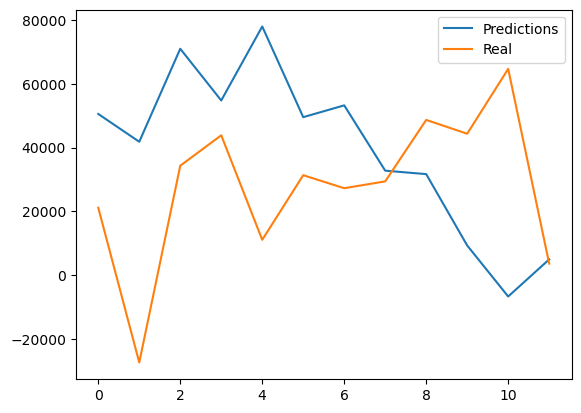

In [194]:
rg = RandomForestRegressor()
rg.fit(X_train, y_train)
predictions = preds_recursive_meta(X_test, rg, horizon)
preds_real = znorm_reverse(pd.Series(predictions), np.mean(preds_start), np.std(preds_start))
real = get_error_series(f'./results/{model_target}_noresid/{derivado}/{transform_target}/transform_{uf}.csv', test_date)
plt.plot(preds_real, label='Predictions')
plt.plot(real, label='Real')  
plt.legend()



In [195]:
series = read_series(f'../datasets/venda/mensal/uf/{derivado}/mensal_{estado.lower()}_{derivado}.csv')
print(derivado)
print(estado)
print(transform_target)
treino, teste = train_test_stats(series, 12)
transformer = STLTransformer(sp=12) 
stl = transformer.fit(treino)
# train_stl = stl.seasonal_ + stl.trend_
train_stl = treino
train_tf = transform_regressors(train_stl, format=transform_target)

oleodiesel
MG
deseasonal


(<Figure size 1600x400 with 1 Axes>, <Axes: >)

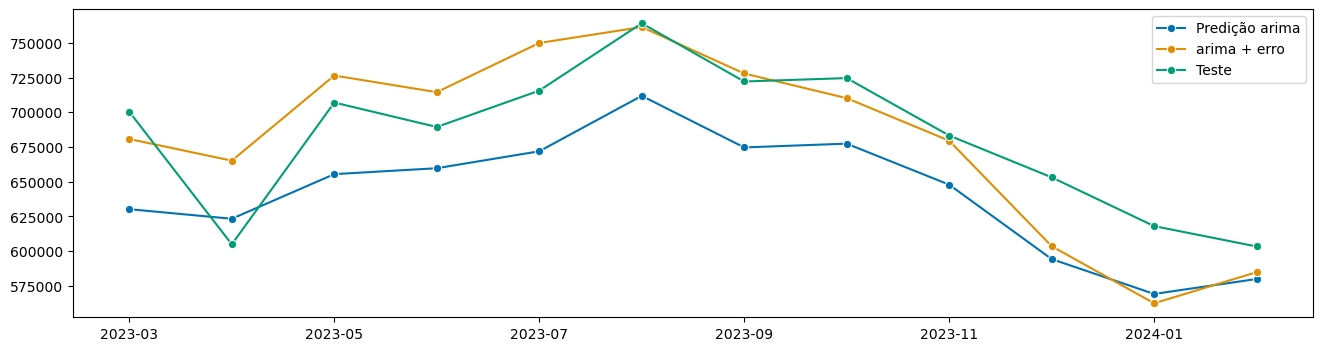

In [196]:

preds_target = get_preds_hybrid(f'./results/{model_target}/{derivado}/{transform_target}/transform_{uf}.csv', "2023-03_2024-02", teste.index)
somados = preds_target + preds_real.values
# preds_target

# plt.plot(preds_target.values, label='Target real')
# plt.plot(somados.values, label='Combinacao com erro')  
# plt.legend()

plot_series(preds_target, somados, teste, labels=[f"Predição {model_target}", f"{model_target} + erro", "Teste"])